# Imports/functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from matplotlib.gridspec import GridSpec
import glob
fs_axislabel = 10
fs_figsubpanel = 14
fs_legend = 8

In [2]:
import itertools
def plot(toplot, options, axs, names=None, colors=None, make=['power','fdr','accuracy'], ylabel=False, xlabel=False,
         xticks=True, legend='', fontsize=12):
    for o, t in enumerate(make):
        if t == 'power':
            for i, repname in enumerate(itertools.product(*options)):
                repname = ''.join(repname)
                name = repname if names is None else names[i]
                color = None if colors is None else colors[i]
                mytoplot = toplot[toplot.repname == repname]
                if len(mytoplot) > 0:
                    axs[o].errorbar(mytoplot.noise + i/200, mytoplot.power,
                                 marker='.',
                                 yerr=mytoplot.power_stderr,
                                 label=name,
                                 color=color)
            if ylabel:
                axs[o].set_ylabel('power', fontsize=fontsize)
            axs[o].set_ylim(-0.05,1.05)
            axs[o].set_yticks([0,1], ['0.0','1.0'])
    
        if t == 'fdr':
            for i, repname in enumerate(itertools.product(*options)):
                repname = ''.join(repname)
                name = repname if names is None else names[i]
                color = None if colors is None else colors[i]
                mytoplot = toplot[toplot.repname == repname]
                if len(mytoplot) > 0:
                    axs[o].errorbar(mytoplot.noise + i/200, mytoplot.nfdr10,
                                 yerr=mytoplot.nfdr10_stderr,
                                 marker='.',
                                 label=name,
                                 color=color)
            if ylabel:
                axs[o].set_ylabel('n FDR 10% patches', fontsize=fontsize)
    
        if t == 'accuracy':
            for i, repname in enumerate(itertools.product(*options)):
                repname = ''.join(repname)
                name = repname if names is None else names[i]
                color = None if colors is None else colors[i]
                mytoplot = toplot[toplot.repname == repname]
                if len(mytoplot) > 0:
                    axs[o].errorbar(mytoplot.noise + i/200, mytoplot.accuracy,
                                 yerr=mytoplot.accuracy_stderr,
                                 marker='.',
                                 label=name,
                                 color=color)
            if ylabel:
                axs[o].set_ylabel('spatial accuracy', fontsize=fontsize)
            axs[o].set_ylim(0.45, 1.05)
            axs[o].set_yticks([0.5,1])
            
    if legend in make:
        axs[make.index(legend)].legend(fontsize=fs_legend)
    if xlabel:
        axs[-1].set_xlabel('noise', fontsize=fontsize)
    for ax in axs:
        if xticks:
            ax.set_xticks(info.noise.unique())
        else:
            ax.set_xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Load data

In [5]:
# read files
signal_type = '*'
results = pd.concat([
    pd.read_csv(f, sep='\t')
    for f in glob.glob(f'../../ALZ/alz-sim/out/finaldraft*/{signal_type}.*.tsv')])
results.repname.value_counts()

repname
trivial-pixels-raw         3192
trivial-avg-raw            3192
trivial-cov-raw            2793
resnetadvancedkl6-raw      1800
simplecnnkl6-latent-raw    1800
trivial-pixels-20pcs       1800
trivial-avg-20pcs          1800
resnetsimplekl6-raw        1800
trivial-cov-20pcs          1800
resnetadvancedkl3-raw       600
resnetadvancedkl8-raw       600
resnetadvancedkl10-raw      600
resnetadvancedkl5-raw       600
resnetadvancedkl2-raw       600
resnetadvancedkl9-raw       600
resnetadvancedkl7-raw       600
resnetadvancedkl1-raw       600
resnetadvancedkl4-raw       600
resnetadvancedkl0-raw       156
Name: count, dtype: int64

In [6]:
# process results
accuracies = []
for signal in results.signal.unique():
    for style in results['style'].unique():
        for repname in results.repname.unique():
            mask = (results.repname==repname) & (results['style']==style) & (results.signal == signal)
            accuracy = results[mask].groupby(by='noise').auroc.aggregate(by="mean").by
            accuracy_std = results[mask].groupby(by='noise').auroc.aggregate(by="std").by
            n = results[mask].noise.value_counts()
            stderr = 2*accuracy_std / np.sqrt(n)
            df = pd.DataFrame({
                'accuracy':accuracy,
                'n':n,
                'accuracy_stderr':stderr})
            df['repname'] = repname
            df['style'] = style
            df['signal'] = signal
            accuracies.append(df)
accuracies = pd.concat(accuracies).reset_index()

powers = []
for signal in results.signal.unique():
    for style in results['style'].unique():
        for repname in results.repname.unique():
            mask = (results.repname==repname) & (results['style']==style) & (results.signal == signal)
            power = results[mask].groupby(by='noise').P.aggregate(by=lambda x:(x<=0.05).mean()).by
            strongpower = results[mask].groupby(by='noise').P.aggregate(by=lambda x:(x<=0.005).mean()).by
            n = results[mask].noise.value_counts()
            stderr = 2*np.sqrt(power*(1-power)/n)
            strongstderr = 2*np.sqrt(strongpower*(1-strongpower)/n)
            df = pd.DataFrame({
                'power':power,
                'power_stderr':stderr,
                'strongpower':strongpower,
                'strongpower_stderr':strongstderr})
            df['repname'] = repname
            df['style'] = style
            df['signal'] = signal
            powers.append(df)
powers = pd.concat(powers).reset_index()

nfdr10s = []
for signal in results.signal.unique():
    for style in results['style'].unique():
        for repname in results.repname.unique():
            mask = (results.repname==repname) & (results['style']==style) & (results.signal == signal)
            nfdr10 = results[mask].groupby(by='noise').nfdr10.aggregate(by="mean").by
            nfdr10_std = results[mask].groupby(by='noise').nfdr10.aggregate(by="std").by
            n = results[mask].noise.value_counts()
            stderr = 2*nfdr10_std / np.sqrt(n)
            df = pd.DataFrame({
                'nfdr10':nfdr10,
                'nfdr10_stderr':stderr})
            df['repname'] = repname
            df['style'] = style
            df['signal'] = signal
            nfdr10s.append(df)
nfdr10s = pd.concat(nfdr10s).reset_index()

info = pd.merge(accuracies, powers, on=['repname','style','signal','noise'])
info = pd.merge(info, nfdr10s, on=['repname','style','signal','noise'])

# Figures

## Main text figure

In [7]:
mainreps = np.array([
    'resnetadvancedkl6-raw',
    'resnetsimplekl6-raw',
    'trivial-pixels-20pcs',
    'trivial-avg-20pcs',
    ])
mainrep_names = ['VIMA', '2-layer CNN', 'PCA of raw pixels', 'Patch avg.']

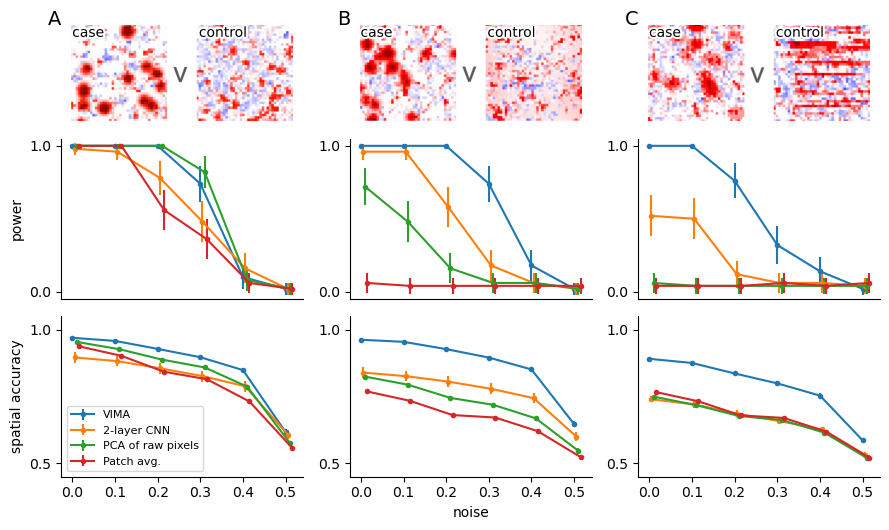

In [22]:
from matplotlib.patheffects import withStroke

fig = plt.figure(figsize=(9, 7/12*9))
gs = GridSpec(3, 3, height_ratios=[0.6, 1, 1])

# add pics of sim types
for i, pic in enumerate(['_media/agg_v_nothing.png', '_media/agg_v_diffuse.png', '_media/agg_v_linear.png']):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(ImageEnhance.Color(Image.open(pic)).enhance(1.7))
    text1 = ax.text(5, 5, 'case', va='top', ha='left', color='k', fontsize=10)
    text2 = ax.text(880, 5, 'control', va='top', ha='left', color='k', fontsize=10)
    for text in [text1, text2]:
        text.set_path_effects([withStroke(linewidth=3, foreground='white')])
    ax.axis('off')

# plot results
ax_power = [fig.add_subplot(gs[1,i]) for i in range(3)]
ax_acc = [fig.add_subplot(gs[2,i]) for i in range(3)]
options = (mainreps,)
for i, signal in enumerate(['agg_v_nothing','agg_v_diffuse','linear_v_circular']):
    toplot = info[(info['style'] == 'cna')&(info.signal == signal)]
    plot(toplot, options,
         ax_power[i:i+1],
         make=['power'], ylabel=i==0, legend='',
         fontsize=fs_axislabel, xticks=False,
         names=mainrep_names)
    plot(toplot, options,
         ax_acc[i:i+1],
         make=['accuracy'], ylabel=i==0, xlabel=i==1, legend='accuracy' if i==0 else '',
         fontsize=fs_axislabel,
         names=mainrep_names)
        
# add subpart labels
fig.tight_layout()
for i in range(3):
    fig.text(ax_power[i].get_position().x0, 1, ['A','B','C'][i], fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.savefig('../_main/fig.power_accuracy.pdf', dpi=800)
plt.show()

## Supp figures

### null simulation

### VIMA but with clustering

### change variational penalty

resnetadvancedkl0-raw
resnetadvancedkl1-raw
resnetadvancedkl2-raw
resnetadvancedkl3-raw
resnetadvancedkl4-raw
resnetadvancedkl5-raw
resnetadvancedkl6-raw
resnetadvancedkl7-raw
resnetadvancedkl8-raw
resnetadvancedkl9-raw
resnetadvancedkl10-raw


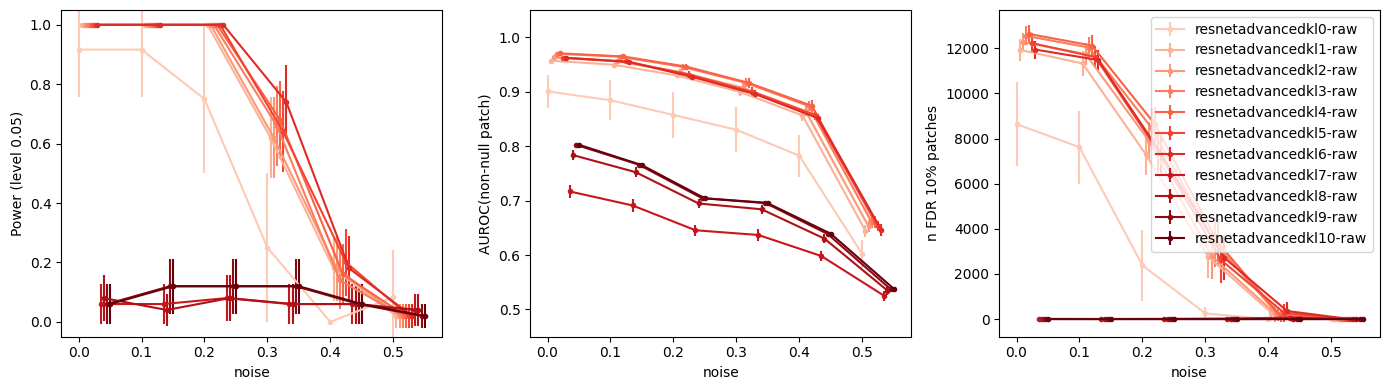

In [43]:
# Varying kl loss weight
fig, axs = plt.subplots(1,3,figsize=(14,4))
toplot = info[(info['style'] == 'cna')&(info.signal == 'agg_v_diffuse')]
options = (
    [
        'resnetadvancedkl0-raw',
        'resnetadvancedkl1-raw',
        'resnetadvancedkl2-raw',
        'resnetadvancedkl3-raw',
        'resnetadvancedkl4-raw',
        'resnetadvancedkl5-raw',
        'resnetadvancedkl6-raw',
        'resnetadvancedkl7-raw',
        'resnetadvancedkl8-raw',
        'resnetadvancedkl9-raw',
        'resnetadvancedkl10-raw',
    ],
)
plot_power_and_accuracy(toplot, options, axs,
    colors=plt.cm.Reds(np.linspace(0.2, 1, 11)))
plt.tight_layout()
plt.show()

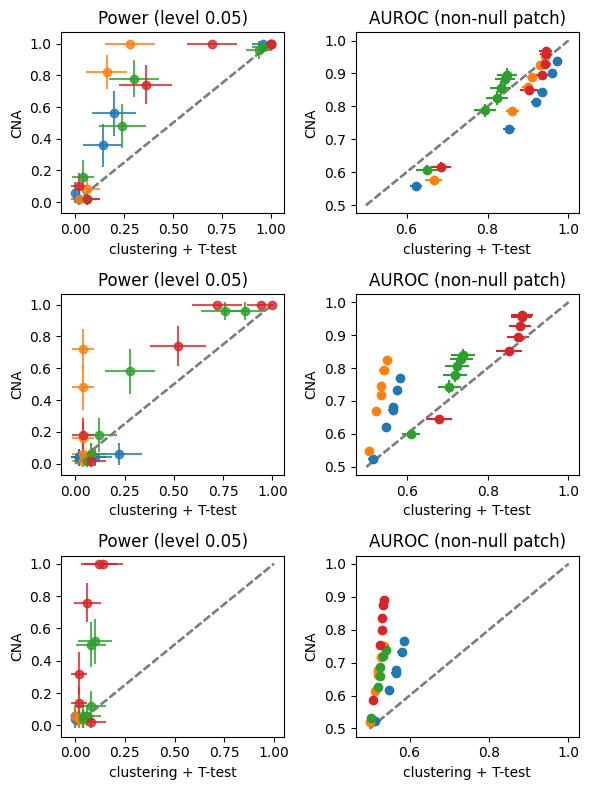

In [32]:
# cna v clustering
df_clust = info[info['style'] == 'clust']
df_cna = info[info['style'] == 'cna']
df_both = pd.merge(df_clust, df_cna, on=['signal', 'repname', 'noise'], how='inner')
fig, allaxs = plt.subplots(3,2,figsize=(6,8))
for axs, signal in zip(allaxs, ['agg_v_nothing','agg_v_diffuse','linear_v_circular']):
    for repname in mainreps:
        toplot = df_both[(df_both.signal == signal)&(df_both.repname == repname)]
        axs[0].errorbar(toplot.power_x, toplot.power_y,
                xerr=toplot.power_stderr_x,
                yerr=toplot.power_stderr_y, marker='o', ls='', label=repname, alpha=0.8)
        axs[0].plot([0,1],[0,1],ls='--', color='gray')
        axs[0].set_title('Power (level 0.05)')
        axs[0].set_xlabel('clustering + T-test')
        axs[0].set_ylabel('CNA')
        axs[1].errorbar(toplot.accuracy_x, toplot.accuracy_y,
                xerr=toplot.accuracy_stderr_x,
                yerr=toplot.accuracy_stderr_y, marker='o', ls='', label=repname)
        axs[1].plot([0.5,1],[0.5,1],ls='--', color='gray')
        axs[1].set_title('AUROC (non-null patch)')
        axs[1].set_xlabel('clustering + T-test')
        axs[1].set_ylabel('CNA')
        # axs[0].legend()
plt.tight_layout()
plt.show()